In [270]:
import control as co
import numpy as np

V_IN, V_OUT = 5, 170
eta = 0.8
f_sw = 130e+3
R_LOAD, C_OUT, R_ESR, L_m = 170 * 33, 6.6e-6, 10e-3, 10e-6
P_OUT = V_OUT * V_OUT / R_LOAD
V_Q, V_D = 0.8, 0.76
N_PS = 10
D = V_OUT * (1 / N_PS) / (V_IN + V_OUT * 1 / N_PS)
f_RT, f_SYNC = f_sw, f_sw
V_SLOPE = 40e-3 * f_RT / f_SYNC
I_SLOPE = 30e-6 * f_RT / f_SYNC
# R_SL = 3.3e+3
R_SL = 0
R_i = 0.005 # 외부 션트 저항
R_T = 2.21 * (10 ** 10) / f_RT - 955
S_n = V_IN * R_i / L_m
# S_n = V_IN * (1 - D) * R_i / L_m # 이건 오타인 거 같음
S_f = V_OUT / (L_m * N_PS) * R_i
S_e = (V_SLOPE + I_SLOPE * R_SL) * f_sw
V_ref = 1
R_FB2 = 3.3e+3
R_FB1 = R_FB2 * (V_OUT - V_ref)
H_div = R_FB2 / (R_FB1 + R_FB2)
G_m = 2e-3
R_COMP_OUT = 10e+6
i_ss = 10e-6
t_ss = 20e-3
C_ss = t_ss * i_ss / (1 - V_IN / V_OUT) / V_ref

G_COMP = 0.142
A_M = G_COMP / N_PS * (V_OUT ** 2) / P_OUT * (1 - D) / ((1 + D) * R_i)
w_z_rhp = (V_OUT ** 2) * ((1 - D) ** 2) / ((N_PS ** 2) * P_OUT * L_m)
# w_z_rhp = (V_OUT ** 2) * ((1 - D) ** 2) / ((N_PS ** 2) * P_OUT * L_m * D) # 오타인 거 같음
f_z_rhp = w_z_rhp / (2 * np.pi)
w_z_esr = 1 / (C_OUT * R_ESR)
f_z_esr = w_z_esr / (2 * np.pi)
w_p_lf = (1 + D) * P_OUT / (C_OUT * (V_OUT ** 2))
f_p_lf = w_p_lf / (2 * np.pi)
w_n = np.pi * f_sw
Q = 1 / np.pi / ((1 - D) * (1 + S_e / S_n) - 1 / 2)

G_co = A_M * co.tf([1 / w_z_esr, 1], [1]) * co.tf([-1 / w_z_rhp, 1], [1]) / (co.tf([1 / w_p_lf, 1], [1]) * co.tf([(1 / w_n) ** 2, 1 / (Q * w_n), 1], [1]))

G_fc = -10
G = 10 ** (G_fc / 20)
f_z_ea, f_p_ea = 10 ** 3, 10 ** 4.5
f_c_ea = np.sqrt(f_z_ea * f_p_ea)
w_z_ea, w_p_ea, w_c_ea = 2 * np.pi * f_z_ea, 2 * np.pi * f_p_ea, 2 * np.pi * f_c_ea
a = np.sqrt(1 + (f_c_ea / f_p_ea) ** 2)
b = np.sqrt(1 + (f_z_ea / f_c_ea) ** 2)
R_2 = f_p_ea * G * (R_FB2 + R_FB1) / ((f_p_ea - f_z_ea) * R_FB2 * G_m) * a / b
C_1 = 1 / (2 * np.pi * f_z_ea * R_2)
C_3 = R_FB2 * G_m / (2 * np.pi * f_p_ea * G * (R_FB2 + R_FB1)) * b / a
G_0 = R_FB2 / (R_FB1 + R_FB2) * G_m * R_2 * C_1 / (C_1 + C_3)
G_EA = G_0 * (1 + co.tf([w_z_ea], [1, 0])) / co.tf([1 / w_p_ea, 1], [1])

G_loop = G_co * G_EA


In [271]:
print(f_z_rhp, f_z_esr, f_p_lf, f_z_ea, f_p_ea, f_c_ea)


46118.76191867423 2411438.5316953836 7.6200050831404935 1000 31622.776601683792 5623.413251903491


In [272]:
print((S_f - S_e) / (S_n + S_e) < 1)
# print(S_e > (S_f - S_n) / 2)
print(S_e, (S_f - S_n) / 2)

True
5200.0 3000.0


In [273]:
print(R_FB1, R_FB2)

557700.0 3300.0


In [274]:
print(R_2, C_1, C_3, R_T, C_ss)

27757.117228659885 5.733842667478598e-09 1.8724110951987687e-10 169045.0 2.060606060606061e-07


In [275]:
print(G_loop)


<TransferFunction>: sys[812]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     -1.471e-10 s^3 - 0.002187 s^2 + 632.2 s + 4.059e+06
--------------------------------------------------------------
6.302e-19 s^5 + 2.87e-13 s^4 + 1.373e-07 s^3 + 0.02089 s^2 + s



In [276]:
print(co.poles(G_loop))


[-1.28304857e+05+387729.51653655j -1.28304857e+05-387729.51653655j
 -1.98691765e+05     +0.j         -4.78779040e+01     +0.j
  0.00000000e+00     +0.j        ]


c:\Users\akswnd98\anaconda3\Lib\site-packages\control\freqplot.py:1440: UserWarning: number of encirclements was a non-integer value; this can happen is contour is not closed, possibly based on a frequency range that does not include zero.
  warnings.warn(
c:\Users\akswnd98\anaconda3\Lib\site-packages\control\freqplot.py:1737: UserWarning: number of encirclements does not match Nyquist criterion; check frequency range and indent radius/direction
  nyquist_responses = nyquist_response(


array([list([<matplotlib.lines.Line2D object at 0x000001428E18D690>, None, <matplotlib.lines.Line2D object at 0x0000014280DA6310>, None])],
      dtype=object)

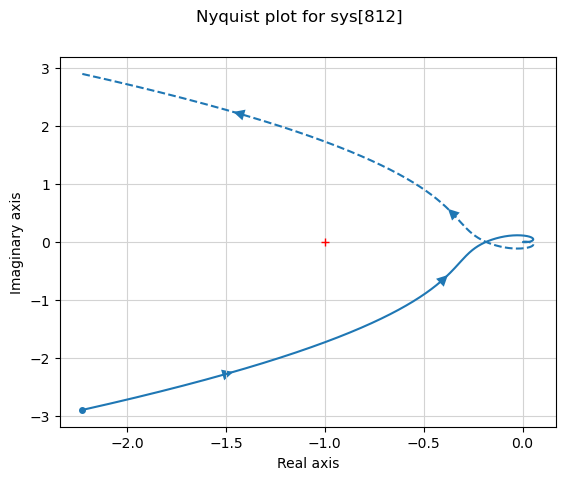

In [277]:
omega = np.linspace(10000, 1000000, 1000000)
co.nyquist_plot(G_loop, omega=omega, max_curve_magnitude=1e18)


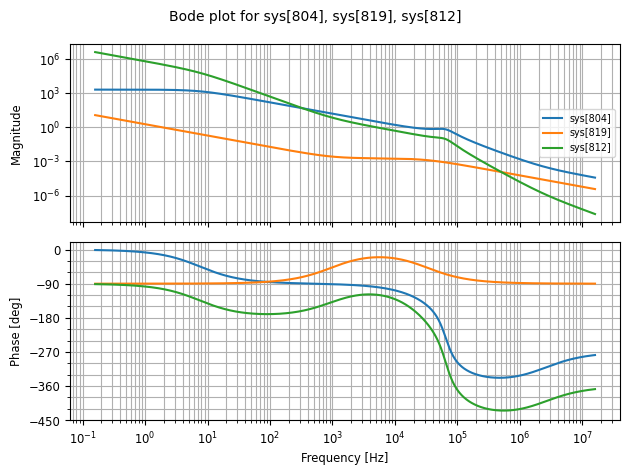

In [278]:
omega = np.logspace(0, 8, 10000)
mag, phase = co.bode(G_co, np.logspace(0, 8, 10000), Hz=True)
mag, phase = co.bode(G_EA * H_div, np.logspace(0, 8, 10000), Hz=True)
mag, phase = co.bode(G_loop, np.logspace(0, 8, 10000), Hz=True)


In [197]:
# 130khz
# 27.6k 3.64n 93.8p
# 6.6u